In [1]:
import os
import pickle
import numpy as np
import scipy.io as sio
import scipy.misc as spm
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


### I'm using IMDB dataset [here]( https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ ) with faces only 6GB, annoations comes in mat file, so cell below handle extracting it to dict

In [2]:
mat_struct = sio.loadmat('imdb.mat')
data_set = [data[0] for data in mat_struct['imdb'][0, 0]]

keys = ['dob',
    'photo_taken',
    'full_path',
    'gender',
    'name',
    'face_location',
        'face_score',
    'second_face_score',
    'celeb_names',
    'celeb_id'
    ]

imdb_dict = dict(zip(keys, np.asarray(data_set)))
imdb_dict['dob'] = [datetime.date.fromordinal(np.max([dob - 366, 1])).year for dob in imdb_dict['dob']]

# Add 'age' key to the dictionary
imdb_dict['age'] = imdb_dict['photo_taken'] - imdb_dict['dob']

### not all data have celeb_names, so remove them, because it make problem with panda dataframe

In [3]:
len(imdb_dict['celeb_names'])

20284

In [4]:
imdb_dict.pop('celeb_names')

array([array(["'Lee' George Quinones"], dtype='<U21'),
       array(["'Weird Al' Yankovic"], dtype='<U19'),
       array(['2 Chainz'], dtype='<U8'), ...,
       array(['Éric Caravaca'], dtype='<U13'),
       array(['Ólafur Darri Ólafsson'], dtype='<U21'),
       array(['Óscar Jaenada'], dtype='<U13')], dtype=object)

In [5]:
da = pd.DataFrame.from_dict(imdb_dict)

In [6]:
da.columns

Index(['age', 'celeb_id', 'dob', 'face_location', 'face_score', 'full_path',
       'gender', 'name', 'photo_taken', 'second_face_score'],
      dtype='object')

### there are some data with age < 0, so remove them

In [7]:
len(da[da['age'] < 0])

493

In [8]:
da = da[da['age'] > 0]

In [9]:
len(da)

460183

### only care about age, path, and second_face_score

In [10]:
da = da[['age','full_path','second_face_score']]

In [11]:
len(da[(da['second_face_score'] != da['second_face_score']) | (da['second_face_score'] < 3)])

394334

### remove images where second_face_score > 3, as second_face_score indicate that there's a second face in image

In [12]:
da = da[(da['second_face_score'] != da['second_face_score']) | (da['second_face_score'] < 3.)]

In [13]:
len(da)

394334

In [14]:
da = da[['age','full_path']]

### full path is an aray of one string, so fix it

In [15]:
da['full_path'][0][0]

'01/nm0000001_rm124825600_1899-5-10_1968.jpg'

In [16]:
da['path'] = da.apply(lambda x:x['full_path'][0], axis=1)

In [17]:
da = da[['age','path']]

### create 10 classes of ages so they have almost equal number of faces images, data size 394334, so each class will have around 36000 data point
### raf, ral is dicionraies for ages range with each class, so class 3 hae ranges in [raf[3],ral[3]]

In [18]:
da['ne_age'] = -1

In [19]:
raf, ral = dict(), dict()

In [20]:
cur_age = 0
for i in range(10):
    raf[i] = cur_age
    while(len(da[da['ne_age'] == i]) < 36200):
        da['ne_age'][da['age'] == cur_age] = i
        cur_age += 1
        if cur_age > 99:
            print(i)
            break
    ral[i] = cur_age-1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9


In [21]:
da = da[da['ne_age'] != -1]

### distrubtions of the 10 classes looks good

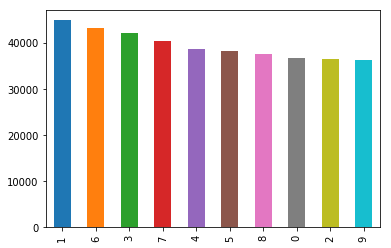

In [22]:
da['ne_age'].value_counts().plot.bar()

In [23]:
for i in range(10):
    print(i,raf[i],ral[i])

0 0 21
1 22 26
2 27 29
3 30 32
4 33 35
5 36 38
6 39 42
7 43 47
8 48 55
9 56 99


### shuffle all data because i'm going to create training files from them and test files, so i want them to be in random order and reset indices

In [24]:
da = da.sample(frac=1).reset_index(drop=True)

In [25]:
len(da)

394195

### save the data to use it later

In [26]:
pickle.dump(da,open('da10c.pkl','wb'))

In [27]:
pickle.dump([raf, ral],open('class_age.pkl','wb'))